In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import erlang
import pandas as pd

np.random.seed(42)

In [2]:
# Parámetros del problema
S0 = 19.9
K = 60
l = 3

PI_I = 0.4
PI_L = 0.6

### **Price Distribution**

$$
P \sim \text{Erlang}(K = 60,\ \lambda = 3)
$$

In [3]:
# PDF de erlang con librería scipy
f = lambda p: erlang.pdf(p, K, scale=1/l)

### **Liquidity Trading Behavior**

In [4]:
def pi_LB(s):
    prob = 0.5 - 0.08*s
    return prob if prob > 0 else 0

def pi_LS(s):
    prob = 0.5 - 0.08*s
    return prob if prob > 0 else 0

def right(A):
    val, _ = quad(lambda p: (p - A) * f(p), A, np.inf)
    return val

def left(B):
    val, _ = quad(lambda p: (B - p) * f(p), 0, B)
    return val

def obj(x):
    bid, ask = x

    u_sell = pi_LB(ask - S0) * (ask - S0)
    u_buy  = pi_LS(S0 - bid) * (S0 - bid)
    u_total = PI_L * (u_sell + u_buy)

    loss_buy = right(ask)
    loss_sell = left(bid)
    loss_total = PI_I * (loss_buy + loss_sell)

    pnl = u_total - loss_total
    return -pnl

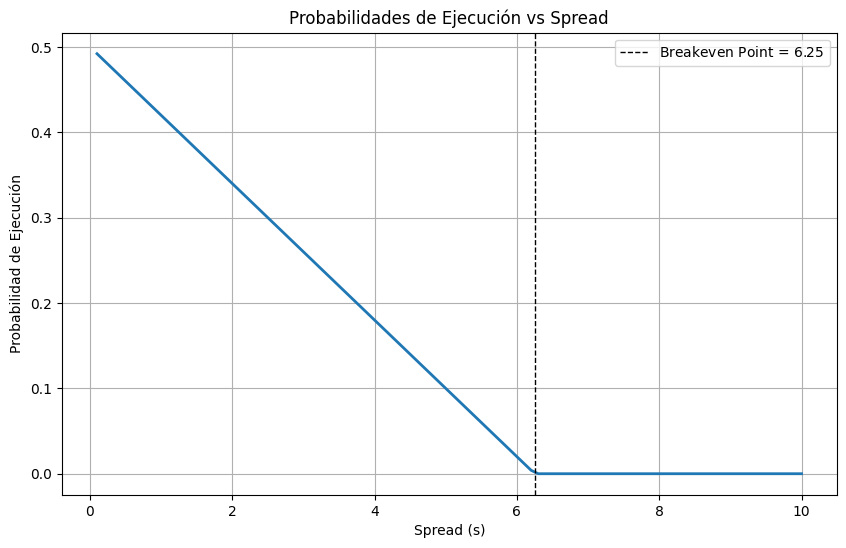

In [23]:
x = np.linspace(0.1, 10, 100)

y_pi_LB = [pi_LB(i) for i in x]

bp = 5/0.8

plt.figure(figsize=(10, 6))
plt.plot(x, y_pi_LB, linewidth=2)
plt.axvline(bp, color='black', linewidth=1, linestyle='--', label = f'Breakeven Point = ${bp}$')
plt.title('Probabilidades de Ejecución vs Spread')
plt.xlabel('Spread (s)')
plt.ylabel('Probabilidad de Ejecución')
plt.legend()
plt.grid()
plt.show()

### **Expected Revenue Analysis (from Copeland and Galai's paper)**

In [6]:
bnds = [(0, S0), (S0, np.inf)]

res = minimize(
    obj,
    x0 = [15, 20],
    bounds = bnds
)

opt_bid, opt_ask = res.x
profit_per_trade = -res.fun

In [7]:
print(f"Profit per Trade: {profit_per_trade:.2f}")

Profit per Trade: 0.84


### **Optimal Bid-Ask Quotes**

In [8]:
print(f"Optimal Bid: {opt_bid:.2f}")
print(f"Optimal Ask: {opt_ask:.2f}")

Optimal Bid: 16.45
Optimal Ask: 23.43


### **Market Simulation**

- Simulate 10,000 trades
- Track cumulative P&L over time, inventory position and individual trade P&L
- Compare 3 different strategies:
    - Optimal Quotes
    - Tight spreads ($B = 19.75, A = 20.25$)
    - Wide Spreads ($B = 18.40, A = 21.40$)

In [9]:
def simulate_trade(B, A, S0, PI_I, PI_L):
    it = 0
    buy = 0
    while True:
        i_l = np.random.rand()
        p = erlang.rvs(K, scale=1/l)
        if np.random.rand() < 0.5:
            # Buy
            if i_l < PI_I:
                # Informado
                if p > A:
                    pl = -(p - A)
                    inv = -1
                    it += 1
                    buy += 1
                else:
                    continue
            else:
                # Liquidez
                if PI_L > pi_LB(A - S0):
                    pl = A - S0
                    inv = -1
                    buy += 1
                else:
                    continue

        else:
            # Sell
            if i_l < PI_I:
                # Informado
                if p < B:
                    pl = -(B - p)
                    inv = 1
                    it += 1
                else:
                    continue
            else:
                # Liquidez
                if PI_L > pi_LS(S0 - B):
                    pl = S0 - B
                    inv = 1
                else:
                    continue

        return pl, inv, it, buy
    
def scenario(num_trades, B, A, S0, PI_I, PI_L):
    history = pd.DataFrame(columns=['P&L', 'Inventory', 'Informed', 'Buy'])

    for i in range(num_trades):
        pl, inv, it, buy = simulate_trade(B, A, S0, PI_I, PI_L)

        history.loc[i] = [pl, inv, it, buy]
        
    return history

In [10]:
tight_bid, tight_ask = 19.75, 20.05
wide_bid, wide_ask = 18.40, 21.40

op_history = scenario(10000, opt_bid, opt_ask, S0, PI_I, PI_L)
tight_history= scenario(10000, tight_bid, tight_ask, S0, PI_I, PI_L)
wide_history= scenario(10000, wide_bid, wide_ask, S0, PI_I, PI_L)

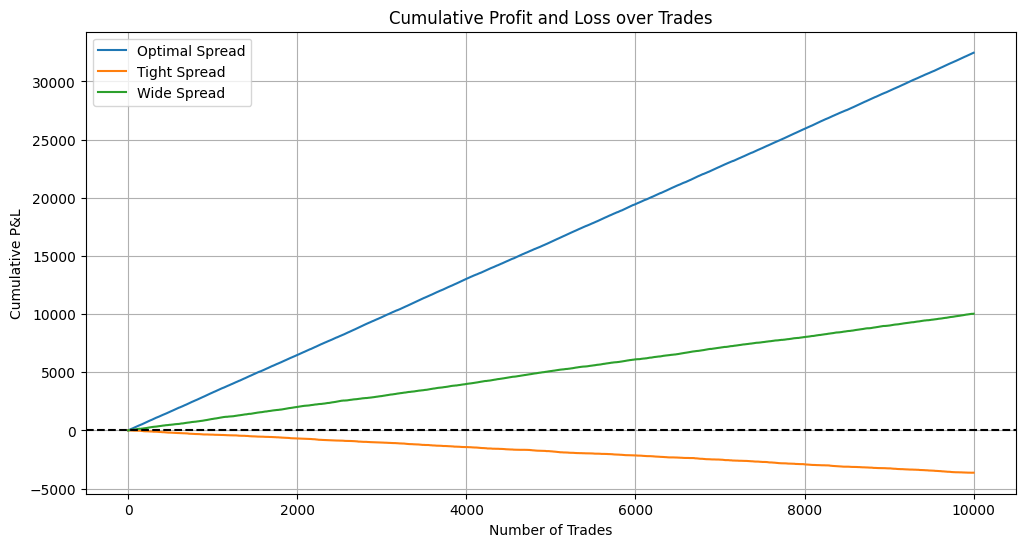

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(op_history['P&L']), label='Optimal Spread')
plt.plot(np.cumsum(tight_history['P&L']), label='Tight Spread')
plt.plot(np.cumsum(wide_history['P&L']), label='Wide Spread')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Cumulative Profit and Loss over Trades')
plt.xlabel('Number of Trades')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.grid()
plt.show()

**Análisis:** Como primera parte, se debe considerar que la simulación fuerza la ejecución de un trade en cada iteración, los resultados deben interpretarse como rentabilidad esperada por trade y no como rentabilidad en el tiempo. Bajo este esquema, un spread más amplio reduce significativamente el impacto de la selección adversa impuesta por traders informados. El spread óptimo genera el mayor P&L acumulado porque maximiza la ganancia por trade y minimiza las pérdidas contra traders informados, sin enfrentar el costo de una menor frecuencia de operación. En contraste, un spread estrecho expone al market maker a pérdidas sistemáticas, ya que no compensa adecuadamente la información asimétrica.

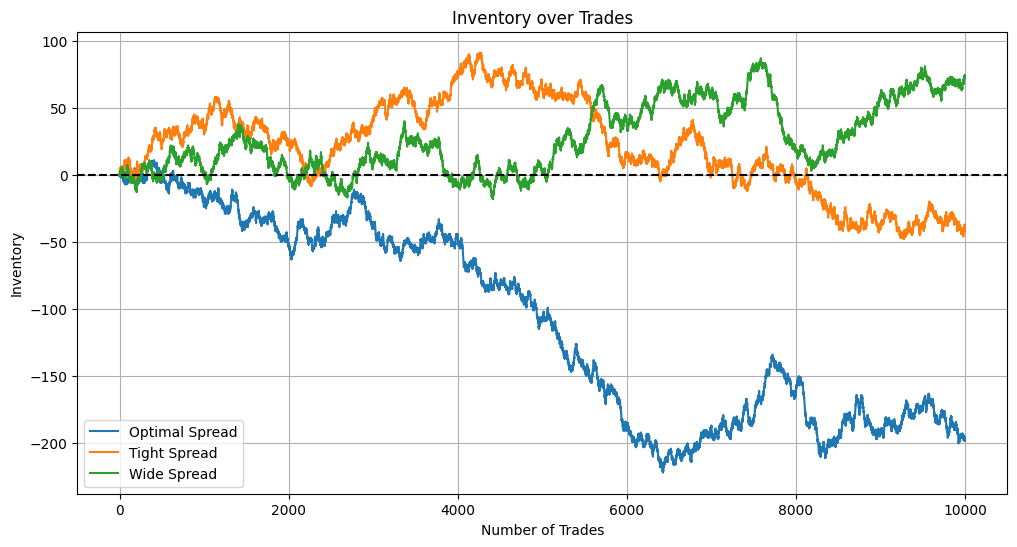

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(op_history['Inventory']), label='Optimal Spread')
plt.plot(np.cumsum(tight_history['Inventory']), label='Tight Spread')
plt.plot(np.cumsum(wide_history['Inventory']), label='Wide Spread')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Inventory over Trades')
plt.xlabel('Number of Trades')
plt.ylabel('Inventory')
plt.legend()
plt.grid()
plt.show()

**Análisis:** Al comparar las trayectorias de inventario, se observa que con el spread óptimo el market maker acumula inventario negativo de forma persistente, lo que indica una posición neta corta (vende más de lo que compra). En cambio, con spreads tight y wide el inventario permanece relativamente cercano a cero, lo que sugiere un flujo de órdenes más balanceado. Este comportamiento es consistente con la simulación, ya que se fuerza un trade en cada iteración y el modelo no impone costos o límites al inventario, por lo que la estrategia óptima puede priorizar rentabilidad y protección ante selección adversa aun si eso implica acumular una posición direccional.

### **Adverse Selection Analysis**
- Informed vs Uninformed trades, sells vs buys
- Average P&Ls, percentage of informed trades

In [13]:
results = pd.DataFrame(columns=['Optimal Spread', 'Tight Spread', 'Wide Spread'])

results.loc['Average P&L'] = [
    round(op_history['P&L'].mean(), 2),
    round(tight_history['P&L'].mean(), 2),
    round(wide_history['P&L'].mean(), 2)
]

results.loc['Final Inventory'] = [
    op_history['Inventory'].sum(),
    tight_history['Inventory'].sum(),
    wide_history['Inventory'].sum()
]

results.loc['% Informed Trades'] = [
    op_history['Informed'].mean() * 100,
    tight_history['Informed'].mean() * 100,
    wide_history['Informed'].mean() * 100
]

results.loc['% Buy Trades'] = [
    op_history['Buy'].mean() * 100,
    tight_history['Buy'].mean() * 100,
    wide_history['Buy'].mean() * 100
]

results

,Optimal Spread,Tight Spread,Wide Spread
Average P&L,3.25,-0.36,1.00
Final Inventory,-198.00,-42.00,74.00
% Informed Trades,5.16,24.01,15.69
% Buy Trades,50.99,50.21,49.63


In [14]:
op_history_mc = [(scenario(1000, opt_bid, opt_ask, S0, PI_I, PI_L))['P&L'].sum() for _ in range(1000)]
tight_history_mc = [(scenario(1000, tight_bid, tight_ask, S0, PI_I, PI_L))['P&L'].sum() for _ in range(1000)]
wide_history_mc = [(scenario(1000, wide_bid, wide_ask, S0, PI_I, PI_L))['P&L'].sum() for _ in range(1000)]

**Why do informed traders induce spreads?**


**How does the adverse selection cost change with spread width?**


**Other risks market makers face (from these results)**



### **Monte Carlo**
- Run 1000 simulations with 1000 trades for the 3 strategies
- Analyze the distribution of the outcomes, include statistics
- Probability of losing money over 1000 trades

In [15]:
gen_history = pd.DataFrame({
    'Optimal Spread': op_history_mc,
    'Tight Spread': tight_history_mc,
    'Wide Spread': wide_history_mc
})

gen_history.describe()

,Optimal Spread,Tight Spread,Wide Spread
count,1000.000000,1000.000000,1000.000000
mean,3230.412315,-369.168031,1010.651523
std,35.020671,39.727050,39.926319
min,3109.616399,-511.451184,875.230398
25%,3207.568104,-396.233968,983.063371
50%,3231.823003,-368.474536,1011.271978
75%,3255.423904,-342.037924,1036.590638
max,3332.358203,-240.139390,1135.296757


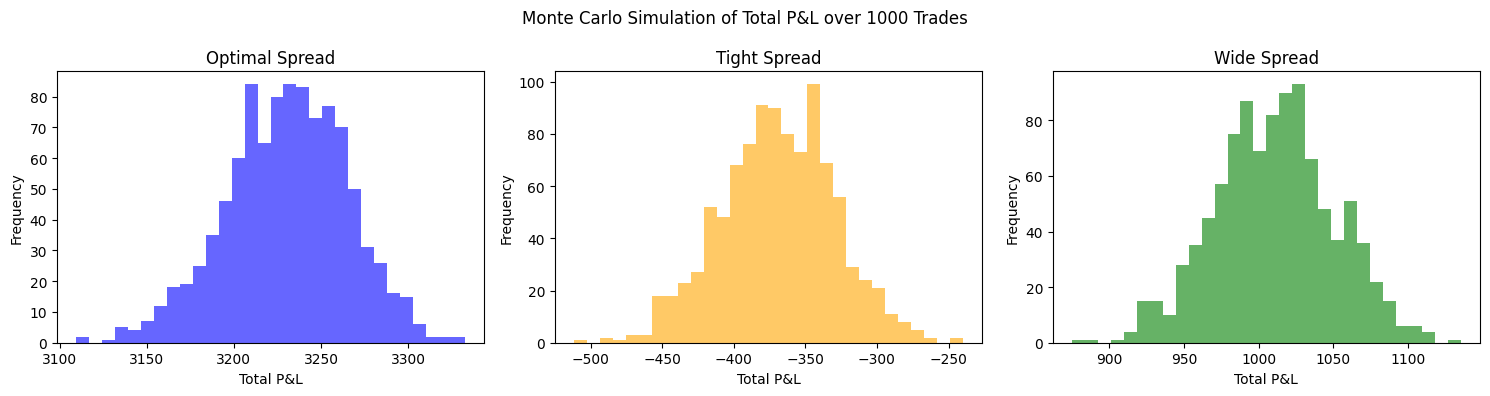

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plt.suptitle('Monte Carlo Simulation of Total P&L over 1000 Trades')

axs[0].hist(op_history_mc, bins=30, color='blue', alpha=0.6)
axs[0].set_title("Optimal Spread")
axs[0].set_xlabel('Total P&L')
axs[0].set_ylabel('Frequency')

axs[1].hist(tight_history_mc, bins=30, color='orange', alpha=0.6)
axs[1].set_title("Tight Spread")
axs[1].set_xlabel('Total P&L')
axs[1].set_ylabel('Frequency')

axs[2].hist(wide_history_mc, bins=30, color='green', alpha=0.6)
axs[2].set_title("Wide Spread")
axs[2].set_xlabel('Total P&L')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [17]:
results_mc = pd.DataFrame(columns = ['Loss %'])

results_mc.loc['Optimal Spread'] = [sum(1 for x in op_history_mc if x < 0) / len(op_history_mc) * 100]
results_mc.loc['Tight Spread'] = [sum(1 for x in tight_history_mc if x < 0) / len(tight_history_mc) * 100]
results_mc.loc['Wide Spread'] = [sum(1 for x in wide_history_mc if x < 0) / len(wide_history_mc) * 100]

results_mc

,Loss %
Optimal Spread,0.0
Tight Spread,100.0
Wide Spread,0.0


### **Economic Insights**
Why do spreads exist?

Real world applications

Model limitations